# Introduction:
This notebook explains how to explore data and extract insights. The notebook is structured in the following way:

● About the Dataset

● Data Summary

● Feature Engineering

● Missing Value Analysis

● Correlation Analysis

● Appendix I: Outlier Analysis

● Appendix II: Data Visulization

# About the Dataset:

## Overview
Those datasets are used to evaluate and quantify the impact of the feature implemented in the Jana's mCent Browser. Samosa and Pekora, two external vendors for Jana, provide the users with autocompletions in the browser's URL bar. And I am aiming at analyzing the performances of those two serach autocompletion providers in terms of revenue generation and extracting insights based on those data records.

## Data Fields
● experiment-aggregates.csv

        ○ tid: unique, anonymous tracking ID for each user        
        ○ variant: configuration variant to which the user was assigned.
            ■ variant 0: Control, no 3rd party auto-completions.
            ■ variant 1: Samosa auto-completions
            ■ variant 2: Pekora auto-completions
        ○ join_timestamp_day: hourly date + timestamp       
        ○ minutes_in_app: total minutes spent in the app during the experiment        
        ○ sessions: total sessions in the app during the experiment        
        ○ search_revenue: total revenue (USD in thousands) generated from searches in the URL bar.        
        ○ programmatic_revenue: total revenue (USD in thousands) generated from display advertising
        
● vendor-engagement.csv

        ○ timestamp_day: hourly date + timestamp
        ○ tid: unique, anonymous tracking ID for each user
        ○ clicks: clicks on a sponsored suggestion
        ○ impressions: the count of suggestions received from the partner and displayed to the user
 
● pekora-data.tsv and samosa-data.csv

        ○ date: date when the revenue was earned
        ○ revenue: revenue (USD in thousands) resulting from engagement with monetization partner


In [2]:
import pandas as pd
import os
import missingno as msno
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from datetime import datetime
import calendar


## Let's read in the dataset! 
ATTN: pekora-data.tsv is a .tsv file and the type of "REVENUE" is object. Using parameter delimiter = '\t' to separate the file 

In [3]:
os.chdir('/Users/Jerry_DYT/Documents/iYM-SW/PyCharm/JanaDataChallenge')
vendor_engagement=pd.read_csv('vendor-engagement.csv')
experiment_aggregates=pd.read_csv('experiment-aggregates.csv')
samosa=pd.read_csv('samosa-data.csv')
pekora=pd.read_csv('pekora-data.tsv',delimiter='\t')

#### Calculate revenue from pekora

1. Using regular expression to replace "$" and then convert the type of "REVENUE" from object to float.
2. Using sum() to calculate revenue

In [4]:
pekora["REVENUE"] = pekora["REVENUE"].replace('[\$]', '', regex=True).astype(float)
revenueFromPekora = pekora["REVENUE"].sum()
revenueFromPekora

15.650000000000004

#### Calculate revenue from samosa

Using sum() to calculate revenue from samosa

In [5]:
revenueFromSamosa = samosa["REVENUE"].sum()
revenueFromSamosa

29.20000000000001

In [6]:
revenueFromPartner = pd.DataFrame({"VARIANT":[0,1,2], "PARTNER_REVENUE":[0,revenueFromSamosa,revenueFromPekora]})
revenueFromPartner

,PARTNER_REVENUE,VARIANT
0,0.00,0
1,29.20,1
2,15.65,2


## Data Summary - experiment_aggregates&vendor_engagement
Have an overview of the dataset:

1. size of the dataset
2. get a glimpse of the data by printing few rows
3. check unique ID values
3. type of the variables

### Shape of the dataset

In [7]:
experiment_aggregates.shape

(32719, 7)

In [8]:
vendor_engagement.shape

(127408, 4)

#### ATTN:

I found that I could concatenate these two files based on the unique ID 'TID'. However, each ID contains several records in vendor_engagement file. So I might combine those records first and then merge with experiment_aggregates by TID afterwards.

According to the outcome, it seems that vendor_engagement contains more users than that present in experiment_aggregates.

### Check the unique values in both .csv files by TID

In [9]:
a = np.unique(vendor_engagement[['TID']].values)
len(a)

26755

### Check the number of unique ID of whose variant value equals to 1 or 2.

In [10]:
Users_by_Partners = experiment_aggregates.loc[experiment_aggregates['VARIANT'] != 0]
b = np.unique(Users_by_Partners[['TID']].values)
len(b)

21759

### Sample of first few rows

In [11]:
experiment_aggregates.head(3)

,TID,VARIANT,JOIN_TIMESTAMP_DAY,MINUTES_IN_APP,SESSIONS,SEARCH_REVENUE,PROGRAMMATIC_REVENUE
0,f1714ea37d61fce3,0,2017-05-24 00:00:00+00:00,12.510117,5,0.0,0.017692
1,e0bd855c6a77e1c0,0,2017-05-24 00:00:00+00:00,5.853667,1,0.0,0.000120
2,5f0c1dae0cf8616,0,2017-05-24 00:00:00+00:00,23.858850,1,0.0,0.000720


In [12]:
vendor_engagement.head(3)

,TIMESTAMP_DAY,TID,CLICKS,IMPRESSIONS
0,5/30/17,7a06629925096916,0,0
1,5/31/17,ca1d9ef0627b933a,1,4
2,6/24/17,2a37a3f328cada7d,0,0


### Variables data type

In [13]:
experiment_aggregates.dtypes

TID                      object
VARIANT                   int64
JOIN_TIMESTAMP_DAY       object
MINUTES_IN_APP          float64
SESSIONS                  int64
SEARCH_REVENUE          float64
PROGRAMMATIC_REVENUE    float64
dtype: object

## Concatenate two files by TID

1. Since each unique TID contains several records in vendor-engagement.csv, I am going to combine and reduce those records from the same TID to one instance, basically summarize all 'clicks' and 'impressions'.
2. Check if all of the TIDS in vendor-engagement.cs are present in  experiment-aggregates.csv. 'NaN' means there is no click or impression sent to the user.


In [14]:
temp = vendor_engagement.reset_index().groupby('TID',sort=True).sum()
temp = temp.drop(['index'],axis=1)
temp = temp.reset_index()
dataset = experiment_aggregates.merge(temp,how='left', on='TID')
dataset

,TID,VARIANT,JOIN_TIMESTAMP_DAY,MINUTES_IN_APP,SESSIONS,SEARCH_REVENUE,PROGRAMMATIC_REVENUE,CLICKS,IMPRESSIONS
0,f1714ea37d61fce3,0,2017-05-24 00:00:00+00:00,12.510117,5,0.00000,0.017692,NaN,NaN
1,e0bd855c6a77e1c0,0,2017-05-24 00:00:00+00:00,5.853667,1,0.00000,0.000120,NaN,NaN
2,5f0c1dae0cf8616,0,2017-05-24 00:00:00+00:00,23.858850,1,0.00000,0.000720,NaN,NaN
3,618ac4f4415331fb,0,2017-05-24 00:00:00+00:00,6.899933,1,0.00000,0.000405,NaN,NaN
4,551b7a951cfbf71e,1,2017-05-24 00:00:00+00:00,9.834267,2,0.00000,0.000240,NaN,NaN
5,7c5284b2d0f90e54,0,2017-05-24 00:00:00+00:00,234.776550,49,0.00624,0.109115,0.0,0.0
6,ea412b13642691c0,0,2017-05-24 00:00:00+00:00,1592.239250,103,0.02400,0.060302,0.0,0.0
7,8876007755aba070,0,2017-05-24 00:00:00+00:00,150.988900,15,0.00528,0.013953,NaN,NaN
8,e201817b67100084,1,2017-05-24 00:00:00+00:00,11.519750,1,0.00048,0.000390,NaN,NaN
9,dc73da78ba97f92e,0,2017-05-24 00:00:00+00:00,5.482933,1,0.00000,0.001002,NaN,NaN


Experiment-aggregates contains 32719 unique ID and vendor-engagement contains 26755 unique ID, which means after concatenation, the new dataset should have 5964 NaNs. 

In [15]:
dataset.isnull().sum()

TID                        0
VARIANT                    0
JOIN_TIMESTAMP_DAY         0
MINUTES_IN_APP             0
SESSIONS                   0
SEARCH_REVENUE             0
PROGRAMMATIC_REVENUE       0
CLICKS                  5964
IMPRESSIONS             5964
dtype: int64

## Feature Engineering - merged dataset

1. Quantify the impact of different features on Variant.
2. Create new columns "date,"hour","weekDay","month" from "JOIN_TIMESTAMP_DAY" column.
3. Drop the JOIN_TIMESTAMP_DAY column as I already extracted useful features from it.
4. Quantify the impact of Weekday on Revenue by Variant. 

### Variant - PROGRAMMATIC_REVENUE
Variant 2 has the highest mean value

In [16]:
proRevenue_Matrix = dataset[['VARIANT','PROGRAMMATIC_REVENUE']].groupby(['VARIANT'], as_index=False).sum()
proRevenue_Matrix

,VARIANT,PROGRAMMATIC_REVENUE
0,0,151.730081
1,1,148.251627
2,2,161.755954


In [17]:
dataset[['VARIANT','PROGRAMMATIC_REVENUE']].groupby(['VARIANT'], as_index=False).mean()

,VARIANT,PROGRAMMATIC_REVENUE
0,0,0.013844
1,1,0.013656
2,2,0.014836


#### Programmatic_Revenue_Samaosa and Programmatic_Revenue_Pekora 

In [18]:
proRevenue_Control = proRevenue_Matrix.loc[proRevenue_Matrix['VARIANT'] == 0, 'PROGRAMMATIC_REVENUE']
proRevenue_Samaosa = proRevenue_Matrix.loc[proRevenue_Matrix['VARIANT'] == 1, 'PROGRAMMATIC_REVENUE']
proRevenue_Pekora = proRevenue_Matrix.loc[proRevenue_Matrix['VARIANT'] == 2, 'PROGRAMMATIC_REVENUE']

### Variant - Search_Revenue
Variant 2 has the highest mean value and max value

In [19]:
seaRevenue_Matrix = dataset[['VARIANT','SEARCH_REVENUE']].groupby(['VARIANT'], as_index=False).sum()
seaRevenue_Matrix

,VARIANT,SEARCH_REVENUE
0,0,29.54736
1,1,25.77648
2,2,29.53440


In [20]:
dataset[['VARIANT','SEARCH_REVENUE']].groupby(['VARIANT'], as_index=False).mean()

,VARIANT,SEARCH_REVENUE
0,0,0.002696
1,1,0.002374
2,2,0.002709


In [21]:
dataset[['VARIANT','SEARCH_REVENUE']].groupby(['VARIANT'], as_index=False).describe()

VARIANT                                    SEARCH_REVENUE            \
     count mean  std  min  25%  50%  75%  max          count      mean   
0  10960.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        10960.0  0.002696   
1  10856.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0        10856.0  0.002374   
2  10903.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0        10903.0  0.002709   

                                                  
        std  min  25%      50%      75%      max  
0  0.010412  0.0  0.0  0.00048  0.00144  0.33888  
1  0.010151  0.0  0.0  0.00000  0.00144  0.36336  
2  0.011874  0.0  0.0  0.00048  0.00144  0.46176

#### Search_Revenue_Samaosa and Search_Revenue_Pekora 

In [22]:
seaRevenue_Control = seaRevenue_Matrix.loc[seaRevenue_Matrix['VARIANT'] == 0, 'SEARCH_REVENUE']
seaRevenue_Samaosa = seaRevenue_Matrix.loc[seaRevenue_Matrix['VARIANT'] == 1, 'SEARCH_REVENUE']
seaRevenue_Pekora = seaRevenue_Matrix.loc[seaRevenue_Matrix['VARIANT'] == 2, 'SEARCH_REVENUE']

## Total revenue generated by Variant

1. Quantify the total revenue by Variant.
2. Visualize the outcome by plotting a bar chart.


In [23]:
totalRevenue = pd.merge(pd.merge(seaRevenue_Matrix, proRevenue_Matrix, on='VARIANT'),revenueFromPartner, on ='VARIANT')
totalRevenue['Total'] = totalRevenue.sum(axis=1)
totalRevenue

,VARIANT,SEARCH_REVENUE,PROGRAMMATIC_REVENUE,PARTNER_REVENUE,Total
0,0,29.54736,151.730081,0.00,181.277441
1,1,25.77648,148.251627,29.20,204.228107
2,2,29.53440,161.755954,15.65,208.940354


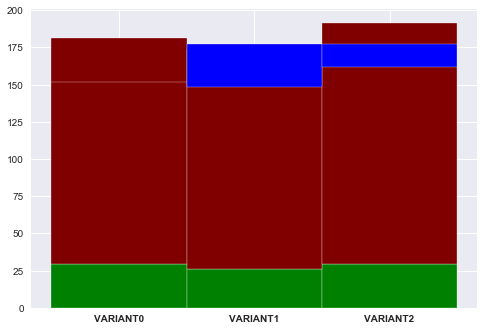

In [24]:
plt.bar(totalRevenue['VARIANT'],totalRevenue['SEARCH_REVENUE'],color='green', edgecolor='white', width=1)
plt.bar(totalRevenue['VARIANT'],totalRevenue['PROGRAMMATIC_REVENUE'],bottom=totalRevenue['SEARCH_REVENUE'],color='maroon', edgecolor='white', width=1)
plt.bar(totalRevenue['VARIANT'],totalRevenue['PARTNER_REVENUE'],bottom=totalRevenue['PROGRAMMATIC_REVENUE'],color='blue', edgecolor='white', width=1)
names = ['VARIANT0','VARIANT1','VARIANT2']
plt.xticks(totalRevenue['VARIANT'], names, fontweight='bold')
plt.show()


### Variant - Minutes_In_App
Variant 2 still has the highest mean value, however Variant 1 has the highest max value among all three categories.

In [25]:
minutes = dataset[['VARIANT','MINUTES_IN_APP']].groupby(['VARIANT'], as_index=False).mean()
minutes

,VARIANT,MINUTES_IN_APP
0,0,209.299009
1,1,211.076907
2,2,213.382374


In [26]:
dataset[['VARIANT','MINUTES_IN_APP']].groupby(['VARIANT'], as_index=False).describe()

VARIANT                                    MINUTES_IN_APP              \
     count mean  std  min  25%  50%  75%  max          count        mean   
0  10960.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        10960.0  209.299009   
1  10856.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0        10856.0  211.076907   
2  10903.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0        10903.0  213.382374   

                                                                        
          std       min       25%        50%         75%           max  
0  483.740205  0.000000  9.193729  31.534250  158.328825   8489.708667  
1  523.260983  0.038183  9.185179  29.810733  151.125067  17688.191630  
2  509.626194  0.000167  9.426375  29.934750  152.540542  11688.634870

#### Minutes_In_App from Samosa and Pekora

In [27]:
mins_Control = minutes.loc[ minutes['VARIANT'] == 0, 'MINUTES_IN_APP']
mins_Samosa = minutes.loc[ minutes['VARIANT'] == 1, 'MINUTES_IN_APP']
mins_Pekora = minutes.loc[ minutes['VARIANT'] == 2, 'MINUTES_IN_APP']

### Variant - Sessions
Variant 0 has the highest mean value, but the mean of Variant 2 is really close to it.

In [28]:
sessions = dataset[['VARIANT','SESSIONS']].groupby(['VARIANT'], as_index=False).mean()
sessions

,VARIANT,SESSIONS
0,0,17.275091
1,1,16.995026
2,2,17.223333


In [29]:
dataset[['VARIANT','SESSIONS']].groupby(['VARIANT'], as_index=False).describe()

VARIANT                                    SESSIONS                        \
     count mean  std  min  25%  50%  75%  max    count       mean        std   
0  10960.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  10960.0  17.275091  31.190041   
1  10856.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  10856.0  16.995026  31.262771   
2  10903.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0  10903.0  17.223333  31.820382   

                               
   min  25%  50%   75%    max  
0  1.0  1.0  3.0  17.0  352.0  
1  1.0  1.0  3.0  15.0  310.0  
2  1.0  1.0  3.0  16.0  316.0

#### Sessions from Samosa and Pekora

In [30]:
sess_Control = sessions.loc[ sessions['VARIANT'] == 0, 'SESSIONS']
sess_Samosa = sessions.loc[ sessions['VARIANT'] == 1, 'SESSIONS']
sess_Pekora = sessions.loc[ sessions['VARIANT'] == 2, 'SESSIONS']

### Creating New Columns 

1. Create "DATE", "WEEKDAY", "MONTH" From "JOIN_TIMESTAMP_DAY" Column
2. Create a TOTALREVENUE column from summarizing "SEARCH_REVENUE" and "PROGRAMMATIC_REVENUE"

In [31]:
dataset["DATE"] = dataset.JOIN_TIMESTAMP_DAY.apply(lambda x : x.split()[0])
dataset["WEEKDAY"] = dataset.DATE.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
dataset["MONTH"] = dataset.DATE.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])
dataset["TOTALREVENUE"] = dataset["SEARCH_REVENUE"] + dataset["PROGRAMMATIC_REVENUE"]
dataset.head(50)

,TID,VARIANT,JOIN_TIMESTAMP_DAY,MINUTES_IN_APP,SESSIONS,SEARCH_REVENUE,PROGRAMMATIC_REVENUE,CLICKS,IMPRESSIONS,DATE,WEEKDAY,MONTH,TOTALREVENUE
0,f1714ea37d61fce3,0,2017-05-24 00:00:00+00:00,12.510117,5,0.00000,0.017692,NaN,NaN,2017-05-24,Wednesday,May,0.017692
1,e0bd855c6a77e1c0,0,2017-05-24 00:00:00+00:00,5.853667,1,0.00000,0.000120,NaN,NaN,2017-05-24,Wednesday,May,0.000120
2,5f0c1dae0cf8616,0,2017-05-24 00:00:00+00:00,23.858850,1,0.00000,0.000720,NaN,NaN,2017-05-24,Wednesday,May,0.000720
3,618ac4f4415331fb,0,2017-05-24 00:00:00+00:00,6.899933,1,0.00000,0.000405,NaN,NaN,2017-05-24,Wednesday,May,0.000405
4,551b7a951cfbf71e,1,2017-05-24 00:00:00+00:00,9.834267,2,0.00000,0.000240,NaN,NaN,2017-05-24,Wednesday,May,0.000240
5,7c5284b2d0f90e54,0,2017-05-24 00:00:00+00:00,234.776550,49,0.00624,0.109115,0.0,0.0,2017-05-24,Wednesday,May,0.115355
6,ea412b13642691c0,0,2017-05-24 00:00:00+00:00,1592.239250,103,0.02400,0.060302,0.0,0.0,2017-05-24,Wednesday,May,0.084302
7,8876007755aba070,0,2017-05-24 00:00:00+00:00,150.988900,15,0.00528,0.013953,NaN,NaN,2017-05-24,Wednesday,May,0.019233
8,e201817b67100084,1,2017-05-24 00:00:00+00:00,11.519750,1,0.00048,0.000390,NaN,NaN,2017-05-24,Wednesday,May,0.000870
9,dc73da78ba97f92e,0,2017-05-24 00:00:00+00:00,5.482933,1,0.00000,0.001002,NaN,NaN,2017-05-24,Wednesday,May,0.001002


### Drop Unncessary Columns
1. Drop "JOIN_TIMESTAMP_DAY" column since I already extracted useful information
2. Drop NaN since those NaNs might impact on correlation analysis below.

In [32]:
dataset  = dataset.drop(["JOIN_TIMESTAMP_DAY"],axis=1)
datasetWithoutNaN = dataset.dropna()
datasetWithoutNaN

,TID,VARIANT,MINUTES_IN_APP,SESSIONS,SEARCH_REVENUE,PROGRAMMATIC_REVENUE,CLICKS,IMPRESSIONS,DATE,WEEKDAY,MONTH,TOTALREVENUE
5,7c5284b2d0f90e54,0,234.776550,49,0.00624,0.109115,0.0,0.0,2017-05-24,Wednesday,May,0.115355
6,ea412b13642691c0,0,1592.239250,103,0.02400,0.060302,0.0,0.0,2017-05-24,Wednesday,May,0.084302
11,a993cb556215b6ce,2,812.339567,44,0.00288,0.006838,0.0,0.0,2017-05-24,Wednesday,May,0.009718
12,17a546eacd3bd149,0,1093.293917,88,0.04320,0.017636,0.0,0.0,2017-05-24,Wednesday,May,0.060836
14,1f24a3fc6ff7bd35,0,22.940783,2,0.00000,0.000757,0.0,0.0,2017-05-24,Wednesday,May,0.000757
16,9c91345fe9b64e4c,0,538.466200,55,0.00432,0.056150,0.0,0.0,2017-05-24,Wednesday,May,0.060470
17,8062d3ec7fc2de8e,1,1.482617,1,0.00000,0.000319,0.0,0.0,2017-05-24,Wednesday,May,0.000319
18,40c0dd58344b7d9b,2,850.859233,89,0.00384,0.037751,0.0,2.0,2017-05-24,Wednesday,May,0.041591
19,e27c59aed96dc769,1,289.122750,70,0.00096,0.014111,17.0,59.0,2017-05-24,Wednesday,May,0.015071
29,c74f8f20acc17b1e,0,227.043200,24,0.00000,0.030925,0.0,0.0,2017-05-24,Wednesday,May,0.030925


## User's Engagement Analysis

In [33]:
totalClicks = datasetWithoutNaN[['VARIANT','CLICKS']].groupby(['VARIANT'], as_index=False).sum()
totalClicks

,VARIANT,CLICKS
0,0,0.0
1,1,7541.0
2,2,225.0


In [34]:
totalImpressions = datasetWithoutNaN[['VARIANT','IMPRESSIONS']].groupby(['VARIANT'], as_index=False).sum() 
totalImpressions

,VARIANT,IMPRESSIONS
0,0,0.0
1,1,183489.0
2,2,5949.0


In [35]:
userEngage = pd.merge(totalClicks,totalImpressions, on = 'VARIANT')
userEngage['CONVERSION_RATE'] = userEngage['CLICKS']/userEngage['IMPRESSIONS']
userEngage

,VARIANT,CLICKS,IMPRESSIONS,CONVERSION_RATE
0,0,0.0,0.0,NaN
1,1,7541.0,183489.0,0.041098
2,2,225.0,5949.0,0.037821


### Impact of Weekday on Revenue by Variant

1. Calculate the mean on Weekday by Variant.
2. Plot line chart to visualize the trend.

In [36]:
dataset[['WEEKDAY','VARIANT','TOTALREVENUE']].groupby(['VARIANT','WEEKDAY'], as_index=False).mean()

,VARIANT,WEEKDAY,TOTALREVENUE
0,0,Friday,0.017023
1,0,Monday,0.019026
2,0,Saturday,0.016689
3,0,Sunday,0.015545
4,0,Thursday,0.016965
5,0,Tuesday,0.016109
6,0,Wednesday,0.014891
7,1,Friday,0.016166
8,1,Monday,0.017161
9,1,Saturday,0.015347


#### ATTN:

Weekday has impact on revenue, the line chart tells us that on weekend the revenue is going to decrease and the revenue will take off from Monday.

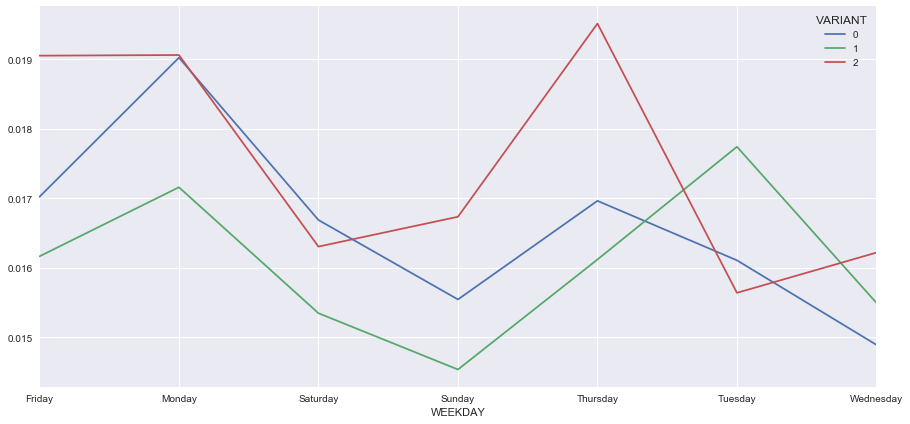

In [37]:
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
dataset.groupby(['WEEKDAY','VARIANT']).mean()['TOTALREVENUE'].unstack().plot(ax=ax)
plt.show()

## Missing value analysis
Once we get hang of the data and columns, next step I geneally am to find out whether dataset has any missing values. Luckily I dont have any missing value in orginal experiment-aggregate dataset. One way which I generally prefer to visualize missing value in the dataset is through "missingno". It's a quiet handy library to quickly visualize variables for missing values.

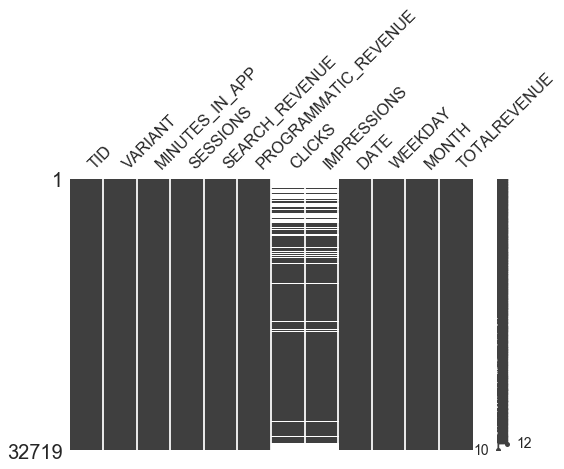

In [38]:
msno.matrix(dataset,figsize=(8,5))

## Correlation Analysis

In order to understand the correlation between numerical features, I'm going to plot the correlation matrix using regression plot in seaborn. The pearson coefficient has a value between -1 and +1, where +1 is totally positive linear correlation and -1 is totally negative linear correlation.

1. Using the preprocessed dataset without NaNs under ClCKS and IMPRESSIONS columns, since NaNs crush correlation analysis.
2. SESSIONS and MINUTES_IN_APP features has got strong postive correlation, that makes sense. Since if users look for more sessions and the minutes increase accordingly.
3. CLICKS and IMPRESSIONS features has a moderate positive relationship, since more impressions will have a higher conversion rate to clicks.
4. SESSIONS positively impacts SEARCH_REVENUE and PROGRAMMATIC_REVENUE most.

ATTN: 

1. IMPRESSIONS and SEARCH_REVENUE got a 0.32 score, which superises me a lot. Since there are so many zeros in IMPRESSIONS. How could the score be higher comparably? I am going to plot a scatter plot to see the distribution with those two features.

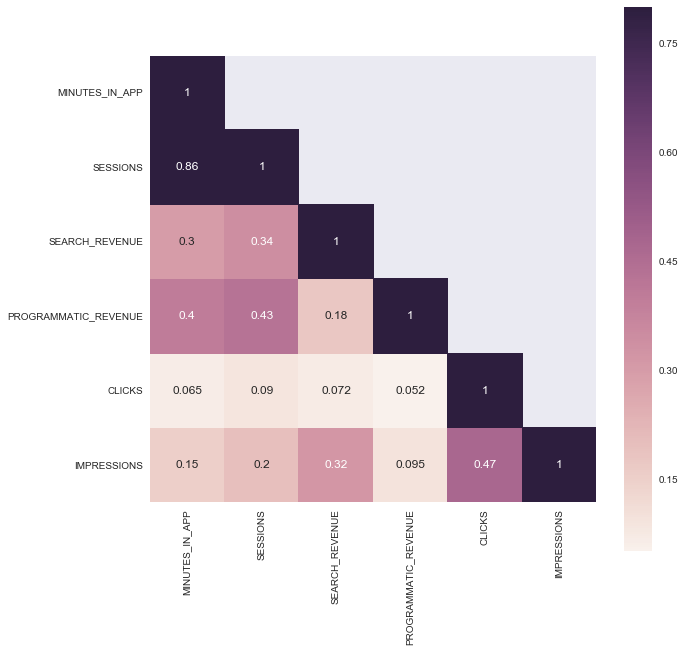

In [43]:
corrMatt = datasetWithoutNaN[["MINUTES_IN_APP","SESSIONS","SEARCH_REVENUE","PROGRAMMATIC_REVENUE","CLICKS","IMPRESSIONS"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(10,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)
plt.show()

### Scatter plot for feature pairs with a higher score

1. Like the higher score indicates, SESSIONS and MINUTES_IN_APP have a strong linear correlation.
2. IMPRESSIONS does have impact on SEARCH_REVENUE and PROGRAMMATIC_REVENUE, but since there might be some outliers acoording to the scatter plot. So I am going to conduct outlier analysis in the next step.

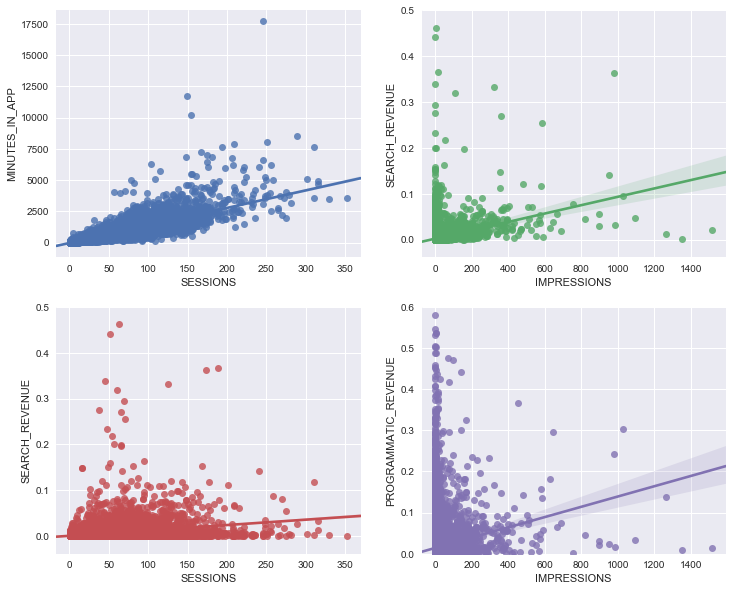

In [44]:
fig,axes = plt.subplots(2,2)
fig.set_size_inches(12, 10)
sn.regplot(x="SESSIONS", y="MINUTES_IN_APP", data=datasetWithoutNaN,ax=axes[0,0])
sn.regplot(x="IMPRESSIONS", y="SEARCH_REVENUE", data=datasetWithoutNaN,ax=axes[0,1])
sn.regplot(x="SESSIONS", y="SEARCH_REVENUE", data=datasetWithoutNaN,ax=axes[1,0])
sn.regplot(x="IMPRESSIONS", y="PROGRAMMATIC_REVENUE", data=datasetWithoutNaN,ax=axes[1,1])
axes[1,1].set(ylim=(0, 0.6))
plt.show()

## Appendix I: Outlier Analysis

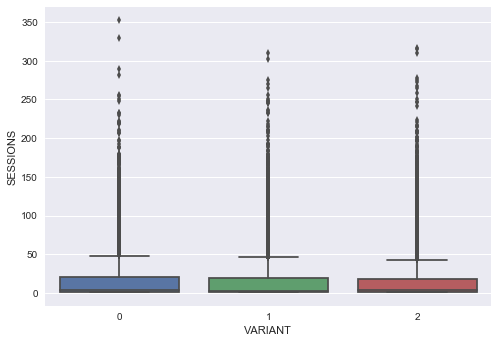

In [45]:
fig, (ax1) = plt.subplots(ncols=1)
sn.boxplot(data=datasetWithoutNaN,y="SESSIONS",x="VARIANT",orient="v",ax=ax1)
plt.show()

In [46]:
datasetWithoutOutliers = datasetWithoutNaN[np.abs(datasetWithoutNaN["SESSIONS"]-datasetWithoutNaN["SESSIONS"].mean())<=(3*datasetWithoutNaN["SESSIONS"].std())] 

In [47]:
print ("Shape Of The Before Ouliers: ",datasetWithoutNaN.shape)
print ("Shape Of The After Ouliers: ",datasetWithoutOutliers.shape)

('Shape Of The Before Ouliers: ', (26755, 12))
('Shape Of The After Ouliers: ', (26123, 12))


## Appendix II: Data Visualization

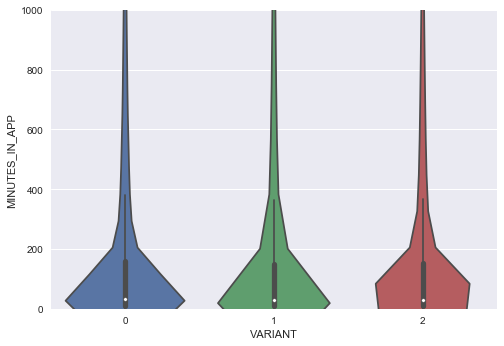

In [48]:
sn.violinplot( x = "VARIANT", y = 'MINUTES_IN_APP', data=dataset)
plt.ylim(0,1000)
plt.show()

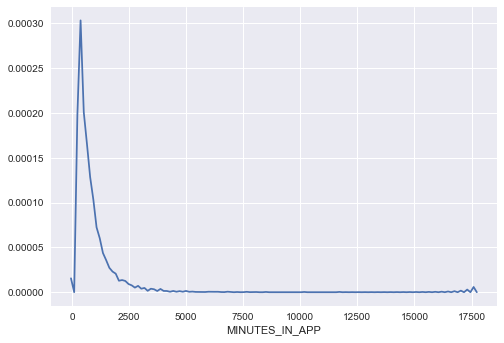

In [49]:
x = dataset['MINUTES_IN_APP']
sn.distplot(x, hist=False)
plt.show()